# CS6476 - PS4

## Simon Le Goff

In [10]:
import cv2
import numpy as np 
#import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import math
from scipy import signal 
from math import *
import random 

SIFT = cv2.xfeatures2d.SIFT_create()

In [26]:
transA=cv2.imread('transA.jpg',cv2.IMREAD_GRAYSCALE)
transB=cv2.imread('transB.jpg',cv2.IMREAD_GRAYSCALE)
simA=cv2.imread('simA.jpg',cv2.IMREAD_GRAYSCALE)
simB=cv2.imread('simB.jpg',cv2.IMREAD_GRAYSCALE)

check=cv2.imread('check.bmp',0)
check_rot=cv2.imread('check_rot.bmp',cv2.IMREAD_GRAYSCALE)

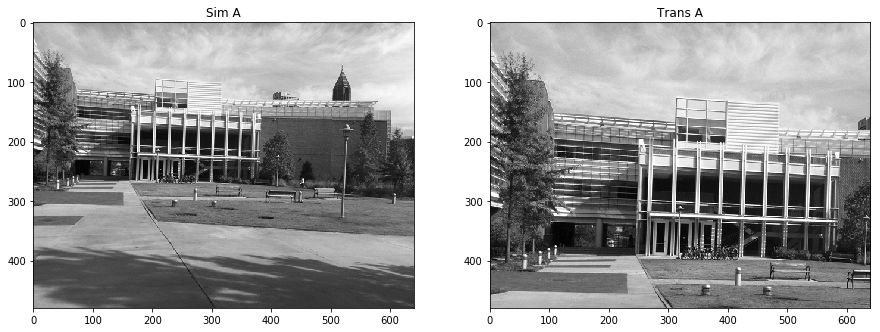

In [6]:
fig=plt.figure(figsize=(15,15))

simA_plt=plt.subplot(121)
simA_plt.title.set_text("Sim A")
plt.imshow(simA,cmap="gray")
transA_plt=plt.subplot(122)
transA_plt.title.set_text("Trans A")
plt.imshow(transA,cmap="gray")

### 1 - Harris Corners

#### 1.1 - Compute gradient-pair image

In [12]:
def compute_gradient(img,ksize):
    gradient_x = cv2.Sobel(img,cv2.CV_64F,1,0,ksize)
    #gradient_x = cv2.normalize(gradient_x, gradient_x, alpha=0, beta=255,
    #                           norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    gradient_y = cv2.Sobel(img,cv2.CV_64F,0,1,ksize)
    #gradient_y= cv2.normalize(gradient_y, gradient_y, alpha=0, beta=255,
    #                           norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return gradient_x,gradient_y

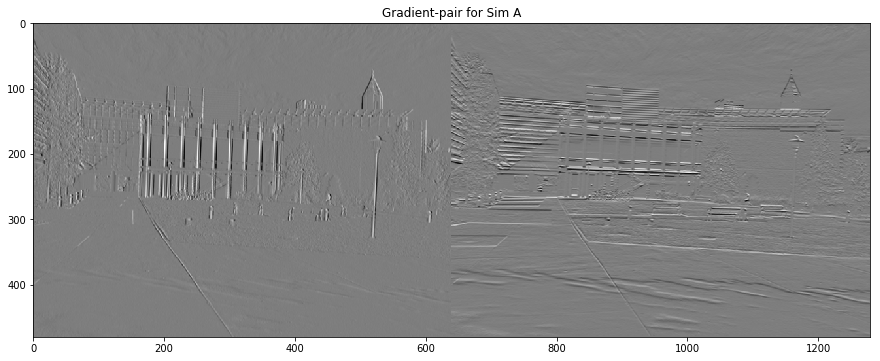

In [8]:
smoothed_simA=cv2.GaussianBlur(simA,(5,5),0)

grad_simA_x,grad_simA_y=compute_gradient(simA,3)

adjoined_gradients_simA=np.hstack((grad_simA_x,grad_simA_y))
fig=plt.figure(figsize=(15,15))
plt.title("Gradient-pair for Sim A")
plt.imshow(adjoined_gradients_simA, cmap="gray") #don't forget cmap !

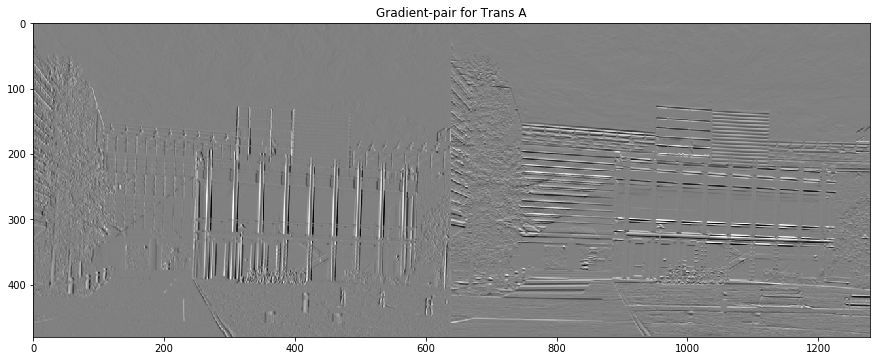

In [9]:
smoothed_transA=cv2.GaussianBlur(transA,(5,5),0)

grad_transA_x,grad_transA_y=compute_gradient(transA,3)

adjoined_gradients_transA=np.hstack((grad_transA_x,grad_transA_y))
fig=plt.figure(figsize=(15,15))
plt.title("Gradient-pair for Trans A")
plt.imshow(adjoined_gradients_transA, cmap="gray") #don't forget cmap !

#### 1.2 - Compute Harris Value

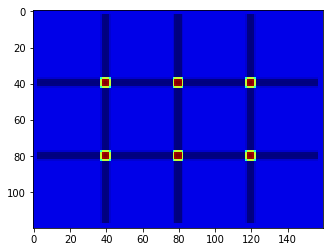

In [40]:
def HarrisValue(img,w_size,alpha): #alpha typically between 0.04 and 0.06
    gradient_x,gradient_y=compute_gradient(img,5)
    
    gauss=cv2.getGaussianKernel(ksize=w_size,sigma=5)
    gauss_window=signal.convolve2d(gauss,gauss.T) #gaussian is a separable filter so we can have a square 
    #gaussian kernel by convolving a column and a line
    
    R=np.zeros((gradient_x.shape[0],gradient_x.shape[1]), dtype=np.float32) #matrix of Harris values 
    Ixx=np.multiply(gradient_x,gradient_x).astype(np.float32)
    Ixy=np.multiply(gradient_x,gradient_y).astype(np.float32)
    Iyy=np.multiply(gradient_y,gradient_y).astype(np.float32)
    
    for r in range (floor(w_size/2),gradient_x.shape[0]-ceil(w_size/2)):
        for c in range (floor(w_size/2),gradient_x.shape[1]-ceil(w_size/2)):
            minr=r-floor(w_size/2)
            maxr=r+ceil(w_size/2)
            minc=c-floor(w_size/2)
            maxc=c+ceil(w_size/2)
            gauss_Ixx=np.multiply(gauss_window,Ixx[minr:maxr,minc:maxc])
            gauss_Ixy=np.multiply(gauss_window,Ixy[minr:maxr,minc:maxc])
            gauss_Iyy=np.multiply(gauss_window,Iyy[minr:maxr,minc:maxc])
            
            M=np.mat([[gauss_Ixx.sum(),gauss_Ixy.sum()],[gauss_Ixy.sum(),gauss_Iyy.sum()]], dtype=np.float32)
            Rval=np.linalg.det(M)-alpha*np.matrix.trace(M)**2
            R[r,c]=Rval
    cv2.normalize(R, R, alpha=0, beta=255,
                   norm_type=cv2.NORM_MINMAX, dtype=-1)#cv2.CV_8U)
    return R

harris_check=HarrisValue(check,5,0.04)
plt.imshow(harris_check,cmap='jet')

In [41]:
harris_simA=HarrisValue(simA,5,0.04)
harris_simB=HarrisValue(simB,5,0.04)

harris_transA=HarrisValue(transA,5,0.04)
harris_transB=HarrisValue(transB,5,0.04)

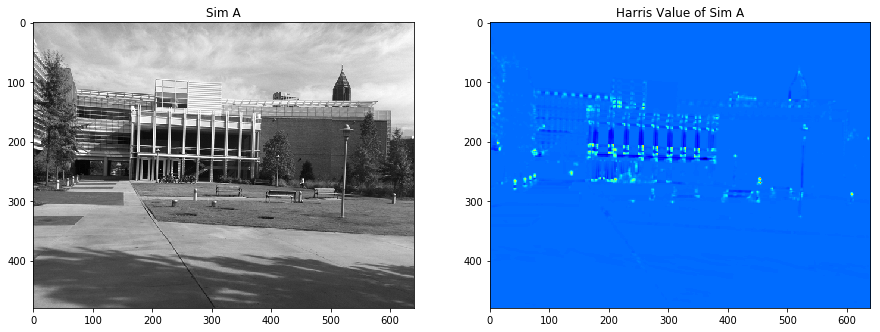

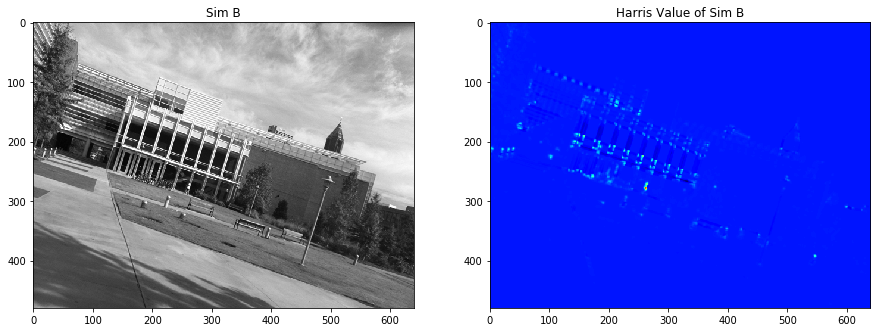

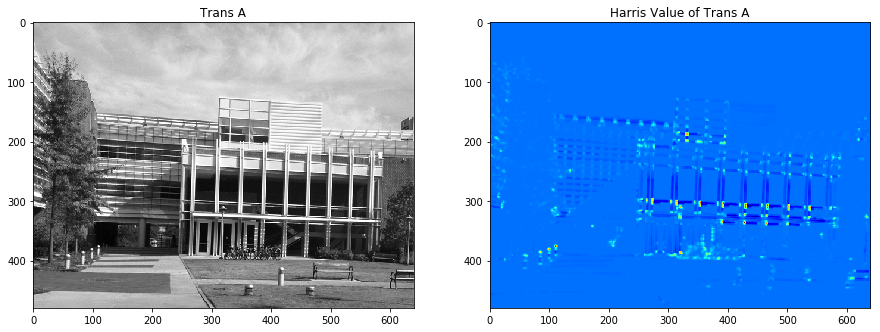

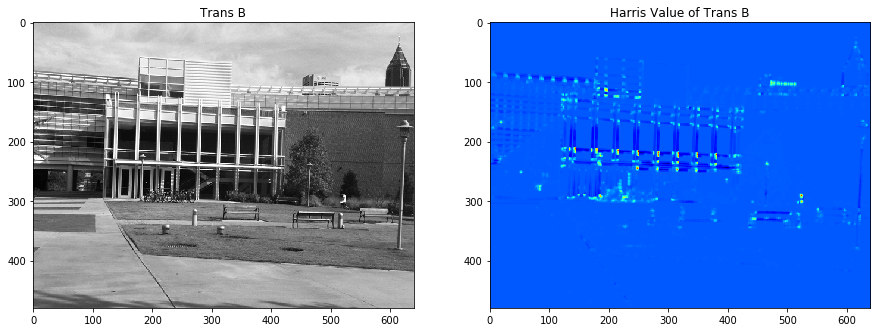

In [42]:
fig_simA=plt.figure(figsize=(15,15))

simA_plt=plt.subplot(121)
simA_plt.title.set_text("Sim A")
plt.imshow(simA,cmap="gray")
transA_plt=plt.subplot(122)
transA_plt.title.set_text("Harris Value of Sim A")
plt.imshow(harris_simA,cmap="jet")

fig_simA=plt.figure(figsize=(15,15))

simA_plt=plt.subplot(121)
simA_plt.title.set_text("Sim B")
plt.imshow(simB,cmap="gray")
transA_plt=plt.subplot(122)
transA_plt.title.set_text("Harris Value of Sim B")
plt.imshow(harris_simB,cmap="jet")

fig_simA=plt.figure(figsize=(15,15))

simA_plt=plt.subplot(121)
simA_plt.title.set_text("Trans A")
plt.imshow(transA,cmap="gray")
transA_plt=plt.subplot(122)
transA_plt.title.set_text("Harris Value of Trans A")
plt.imshow(harris_transA,cmap="jet")

fig_simA=plt.figure(figsize=(15,15))

simA_plt=plt.subplot(121)
simA_plt.title.set_text("Trans B")
plt.imshow(transB,cmap="gray")
transA_plt=plt.subplot(122)
transA_plt.title.set_text("Harris Value of Trans B")
plt.imshow(harris_transB,cmap="jet")

#### 1.3 - Threshold / Non-Maximal Suppression

In [123]:
def non_max_supp(harris_value,w_size,threshold):
    #first apply threshold
    ret,thresh_harris=cv2.threshold(harris_value,threshold*255,255,cv2.THRESH_TOZERO)
    
    new_harris=thresh_harris.copy()
    
    for r in range (floor(w_size/2),harris_value.shape[0]-ceil(w_size/2)):
        for c in range (floor(w_size/2),harris_value.shape[1]-ceil(w_size/2)):
            minhr=r-floor(w_size/2)
            maxhr=r+ceil(w_size/2)
            minhc=c-floor(w_size/2)
            maxhc=c+ceil(w_size/2)
            
            harris_win=new_harris[minhr:maxhr,minhc:maxhc]
            
            max_coord=np.unravel_index(harris_win.argmax(), harris_win.shape)            
                        
            local_max=harris_win[max_coord[0],max_coord[1]]
            harris_win=np.zeros((w_size,w_size))
            
            harris_win[max_coord[0],max_coord[1]]=local_max
            
            new_harris[minhr:maxhr,minhc:maxhc]=harris_win          

    return new_harris

In [124]:
harris_corners_transA=non_max_supp(harris_transA,10,0.4)
harris_corners_transB=non_max_supp(harris_transB,10,0.3)

harris_corners_simA=non_max_supp(harris_simA,10,0.3)
harris_corners_simB=non_max_supp(harris_simB,10,0.2)

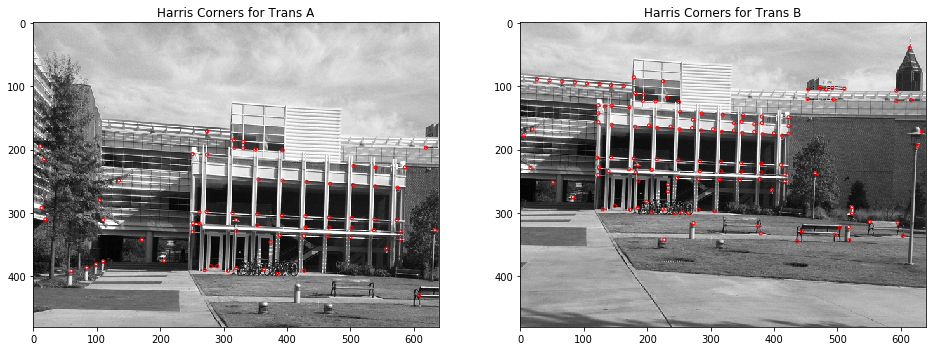

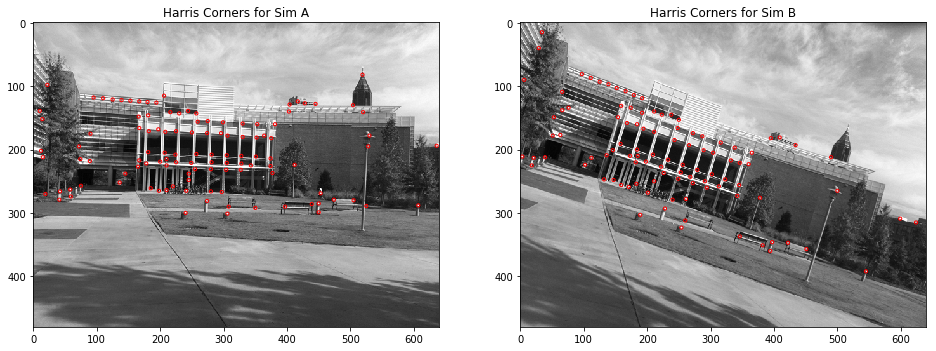

In [127]:
max_coord_ta=np.argwhere(harris_corners_transA>0)
max_coord_tb=np.argwhere(harris_corners_transB>0)

max_coord_sa=np.argwhere(harris_corners_simA>0)
max_coord_sb=np.argwhere(harris_corners_simB>0)

plt.figure(figsize=(16,10))
cor_transA=plt.subplot(121)
cor_transA.title.set_text("Harris Corners for Trans A")
plt.imshow(transA, cmap="gray")
plt.scatter(
    x=[pt[1] for pt in max_coord_ta], 
    y=[pt[0] for pt in max_coord_ta], 
    s=10, facecolors="none", edgecolors="r"
)
cor_transB=plt.subplot(122)
cor_transB.title.set_text("Harris Corners for Trans B")
plt.imshow(transB, cmap="gray")
plt.scatter(
    x=[pt[1] for pt in max_coord_tb], 
    y=[pt[0] for pt in max_coord_tb], 
    s=10, facecolors="none", edgecolors="r"
)

plt.show()

plt.figure(figsize=(16,10))
cor_simA=plt.subplot(121)
cor_simA.title.set_text("Harris Corners for Sim A")
plt.imshow(simA, cmap="gray")
plt.scatter(
    x=[pt[1] for pt in max_coord_sa], 
    y=[pt[0] for pt in max_coord_sa], 
    s=10, facecolors="none", edgecolors="r"
)
cor_simB=plt.subplot(122)
cor_simB.title.set_text("Harris Corners for Sim B")
plt.imshow(simB, cmap="gray")
plt.scatter(
    x=[pt[1] for pt in max_coord_sb], 
    y=[pt[0] for pt in max_coord_sb], 
    s=10, facecolors="none", edgecolors="r"
)
plt.show()

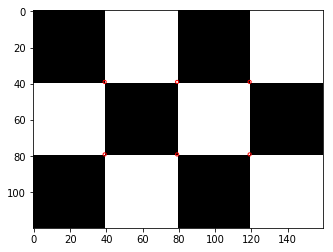

In [128]:
harris_corners_check=non_max_supp(harris_check,20,0.9)
max_coord_check=np.argwhere(harris_corners_check>0)

plt.imshow(check, cmap="gray")
plt.scatter(
    x=[pt[1] for pt in max_coord_check], 
    y=[pt[0] for pt in max_coord_check], 
    s=10, facecolors="none", edgecolors="r"
)

# 2. SIFT Features

#### 2.1

In [129]:
def compute_angle(Ix,Iy):
    return np.arctan2(Iy,Ix)*180/pi


In [130]:
gradx_check,grady_check=compute_gradient(check,5)

angle_check=compute_angle(gradx_check,grady_check)

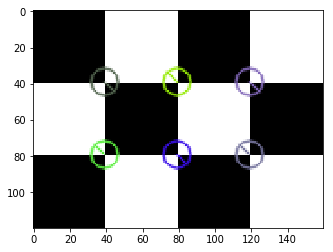

In [132]:
harris_corner_check=non_max_supp(harris_check,10,0.4)
max_coord_check=np.argwhere(harris_corner_check>0)

keypoint_check=[cv2.KeyPoint(corner_check[1],
                             corner_check[0],
                             _size=15,
                             _angle=angle_check[corner_check[0],corner_check[1]])
                for corner_check in max_coord_check]

copy_check=check.copy()

draw_keypoint_check=cv2.drawKeypoints(check,
                 keypoint_check,
                copy_check,
                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(draw_keypoint_check,cmap='gray')

In [135]:
keypoint_transa=[cv2.KeyPoint(corner_transa[1],
                             corner_transa[0],
                             _size=15,
                             _angle=compute_angle(corner_transa[0],corner_transa[1]))
                for corner_transa in max_coord_ta]

keypoint_transb=[cv2.KeyPoint(corner_transb[1],
                             corner_transb[0],
                             _size=15,
                             _angle=compute_angle(corner_transb[0],corner_transb[1]))
                for corner_transb in max_coord_tb]

keypoint_sima=[cv2.KeyPoint(corner_sima[1],
                             corner_sima[0],
                             _size=15,
                             _angle=compute_angle(corner_sima[0],corner_sima[1]))
                for corner_sima in max_coord_sa]

keypoint_simb=[cv2.KeyPoint(corner_simb[1],
                             corner_simb[0],
                             _size=15,
                             _angle=compute_angle(corner_simb[0],corner_simb[1]))
                for corner_simb in max_coord_sb]


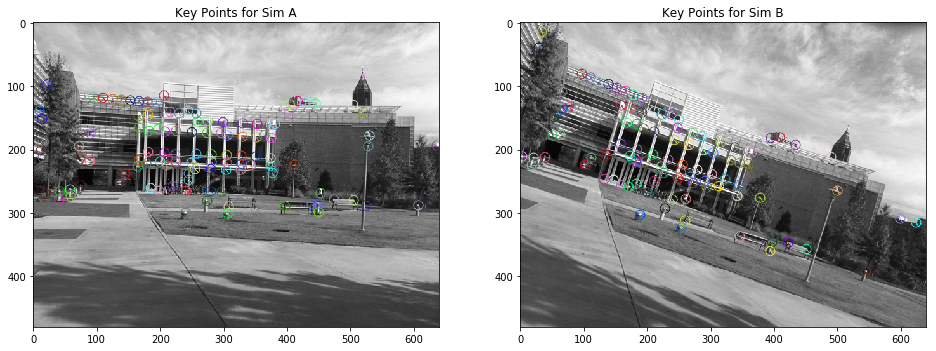

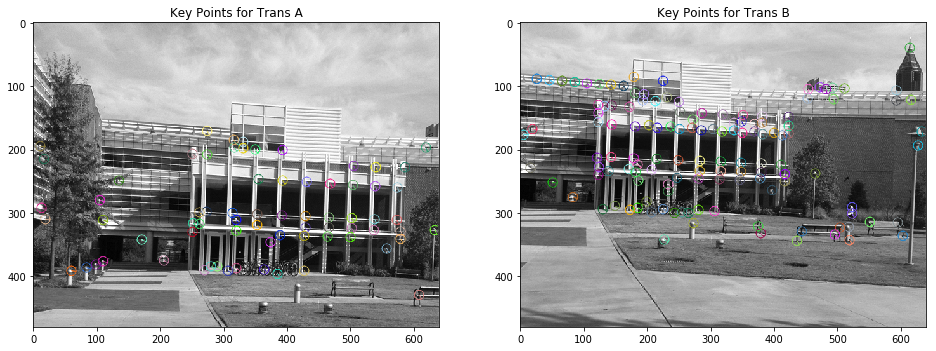

In [137]:
copy_transA=transA.copy()
copy_transB=transB.copy()
copy_simA=simA.copy()
copy_simB=simB.copy()

draw_keypoint_transa=cv2.drawKeypoints(transA,
                 keypoint_transa,
                copy_transA,
                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

draw_keypoint_transb=cv2.drawKeypoints(transB,
                 keypoint_transb,
                copy_transB,
                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

draw_keypoint_sima=cv2.drawKeypoints(simA,
                 keypoint_sima,
                copy_simA,
                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

draw_keypoint_simb=cv2.drawKeypoints(simB,
                 keypoint_simb,
                copy_simB,
                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(16,10))
plot_simA=plt.subplot(121)
plot_simA.title.set_text("Key Points for Sim A")
plt.imshow(draw_keypoint_sima,cmap='gray')
plot_simB=plt.subplot(122)
plot_simB.title.set_text("Key Points for Sim B")
plt.imshow(draw_keypoint_simb,cmap='gray')

plt.figure(figsize=(16,10))
plot_simA=plt.subplot(121)
plot_simA.title.set_text("Key Points for Trans A")
plt.imshow(draw_keypoint_transa,cmap='gray')
plot_simA=plt.subplot(122)
plot_simA.title.set_text("Key Points for Trans B")
plt.imshow(draw_keypoint_transb,cmap='gray')

#### 2.2 - Putative-pair-image

In [184]:
sift = cv2.xfeatures2d.SIFT_create()


def matching_keypoints(im_first,kp_first,im_sec,kp_sec):
    #difference between train and query: 
    #train is the image you learned (in which you extracted the features) - FIRST
    #query is the image you are trying to match with the one trained - SECOND
    
    #sift.compute computes the descriptors for keypoints found 
    _,des1=sift.compute(im_first,kp_first)
    _,des2=sift.compute(im_sec,kp_sec)
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)
    
    putative_image=np.hstack((im_first,im_sec))
    
    #apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])
    
    for m in good:
        train_idx=m[0].trainIdx
        query_idx=m[0].queryIdx
        point_first=kp_first[train_idx].pt #pt is the attribute to get the coordinates of the keypoint 
        point_second=kp_sec[query_idx].pt
        
        x_first=int(point_first[1])
        y_first=int(point_first[0])
        x_second=int(point_second[1])
        y_second=int(point_second[0])+np.shape(im_first)[0]
        
        putative_image=cv2.line(putative_image, (x_first,y_first), (x_second,y_second), color=np.random.rand(3,), thickness=2)
    return putative_image

This is from CV documentation. 

matches is a list of DMatch objects. DMatch object has the following attributes: / DMatch.distance - Distance between descriptors. The lower, the better it is. / DMatch.trainIdx - Index of the descriptor in train descriptors / DMatch.queryIdx - Index of the descriptor in query descriptors / DMatch.imgIdx - Index of the train image.

In [183]:
putative_trans=matching_keypoints(transA,keypoint_transa,transB,keypoint_transb)
plt.imshow(putative_trans)

IndexError: list index out of range

At thi stage I got issues I could not solve. 